# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/gaia/
!ls

# Install

In [1]:
# ! pip install healpy --quiet
# ! pip install wget --quiet

# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable ## for Plotting L.O.S Samples
import matplotlib.gridspec as gridspec

from scipy.signal import savgol_filter, convolve, windows
import scipy.constants as sp

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.6.0+cu124
torch.version.cuda:  12.4
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
dust3d_data_path = data_path / 'dust3d'
dust3d_spectra_path = dust3d_data_path / 'spectra'

gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'



GASS_data_path = ml_data_path / 'GASS'

hi_dust_data_file = dust3d_data_path / 'hi_dust_distances.npz'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/GASKAP

/content/gdrive/MyDrive/Colab Notebooks/GASKAP


# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

In [ ]:
# non_hiabs_srcs = non_hiabs_df['comp_name'].values
# non_hiabs_srcs

# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# 3D dust vs HI

In [ ]:
hi3d_data = np.load(hi_dust_data_file)
hi3d_data.keys()

In [ ]:
for hx in hi3d_data.keys():
    print(hx)

ppdcube
ppvcube
Vd
V
vlsrmat
distmat
header


In [ ]:
vlsr_dist_dict_file = dust3d_data_path / 'hi_vlsr_3d_dust.pkl'

with open(vlsr_dist_dict_file, 'rb') as f:
    vlsr_dist_dict = pickle.load(f)

vlsr_dist_dict.keys()

hi_tau_max_vlsr_arr = vlsr_dist_dict['vlsr']
hi_tb_max_vlsr_arr = vlsr_dist_dict['tb_vlsr']
dust_tau_max_dist_arr = vlsr_dist_dict['distances']

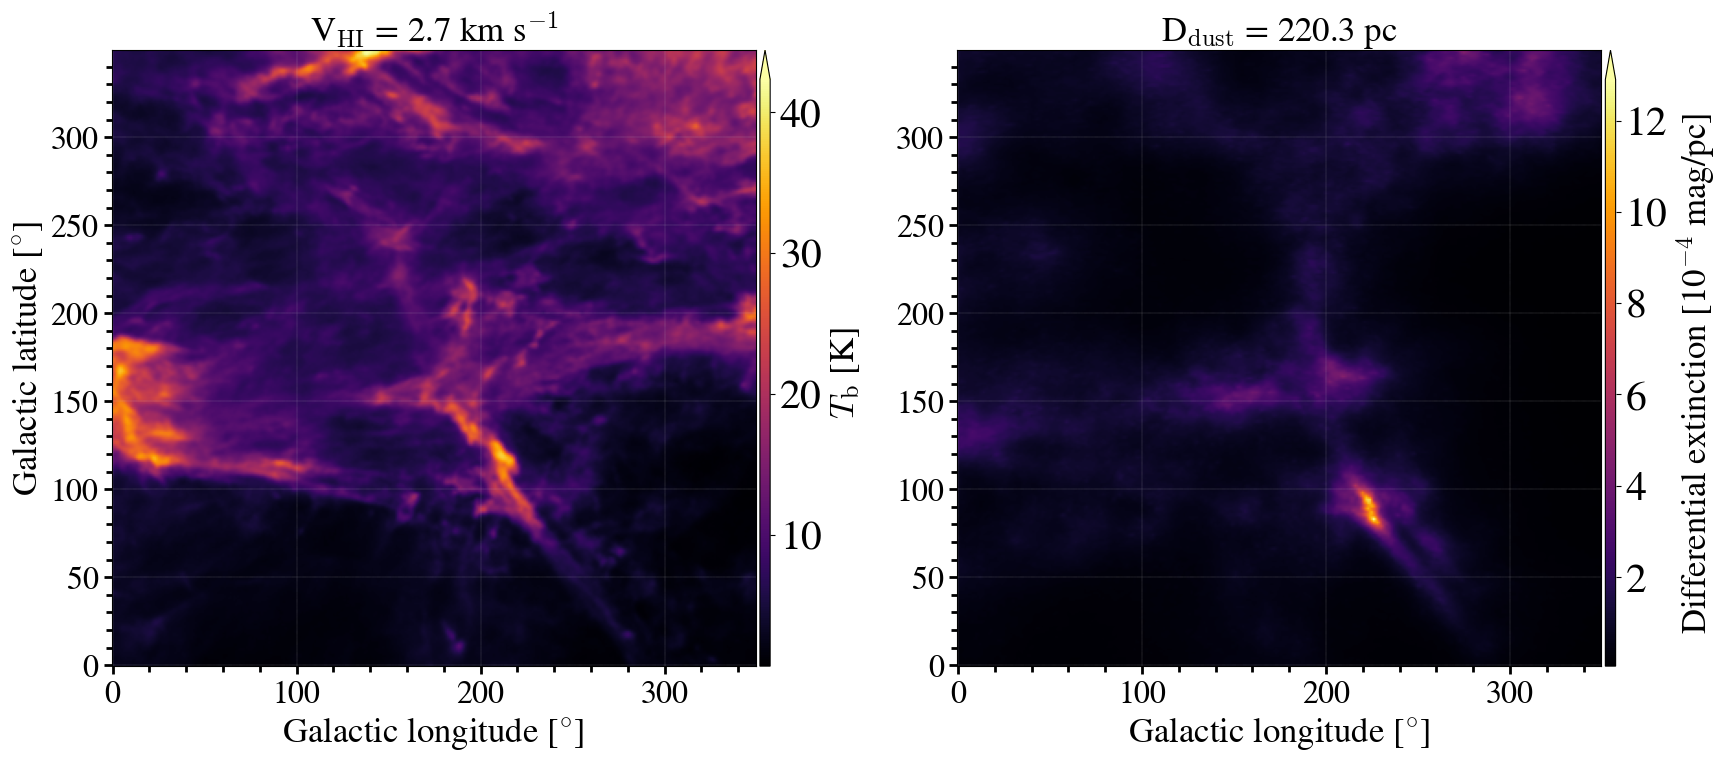

In [ ]:
xlbs = 25
tlbs = 23
cmap = 'viridis'

cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


# Plot
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121) # projection=w

# Display the moment map image
im = ax.imshow(hi3d_data['ppvcube'][28, :, :], cmap='inferno', origin='lower', aspect='auto')


# Title
ax.set_title("V$_\mathrm{HI}$ = 2.7 km s$^{-1}$", fontsize=xlbs)

# Add axes labels
ax.set_xlabel('Galactic longitude [$^{\circ}$]', fontsize=xlbs)
ax.set_ylabel('Galactic latitude [$^{\circ}$]', fontsize=xlbs)

# Color bar
cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', fraction=0.08, pad=0.006, aspect=60)
cbar.ax.set_ylabel('$T_\mathrm{b}$ [K]', rotation=90, labelpad=5., fontsize=xlbs)
cbar.ax.tick_params(labelsize=30)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)




################
ax = fig.add_subplot(122) # projection=w

dxfactor = 2.8 * 5.8e21 # See section 2.1, below Fig 3, https://www.aanda.org/articles/aa/pdf/2025/03/aa53022-24.pdf

# Display image
im = ax.imshow(1.e4*hi3d_data['ppdcube'][221, :, :]/dxfactor, cmap='inferno', origin='lower', aspect='auto')

# Title
ax.set_title("D$_\mathrm{dust}$ = 220.3 pc", fontsize=xlbs)

# Add axes labels
ax.set_xlabel('Galactic longitude [$^{\circ}$]', fontsize=xlbs)


# Color bar
cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', fraction=0.08, pad=0.006, aspect=60)
cbar.ax.set_ylabel('Differential extinction [10$^{-4}$ mag/pc]', rotation=90, labelpad=5., fontsize=xlbs)
cbar.ax.tick_params(labelsize=30)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.
                    )



plt.show()

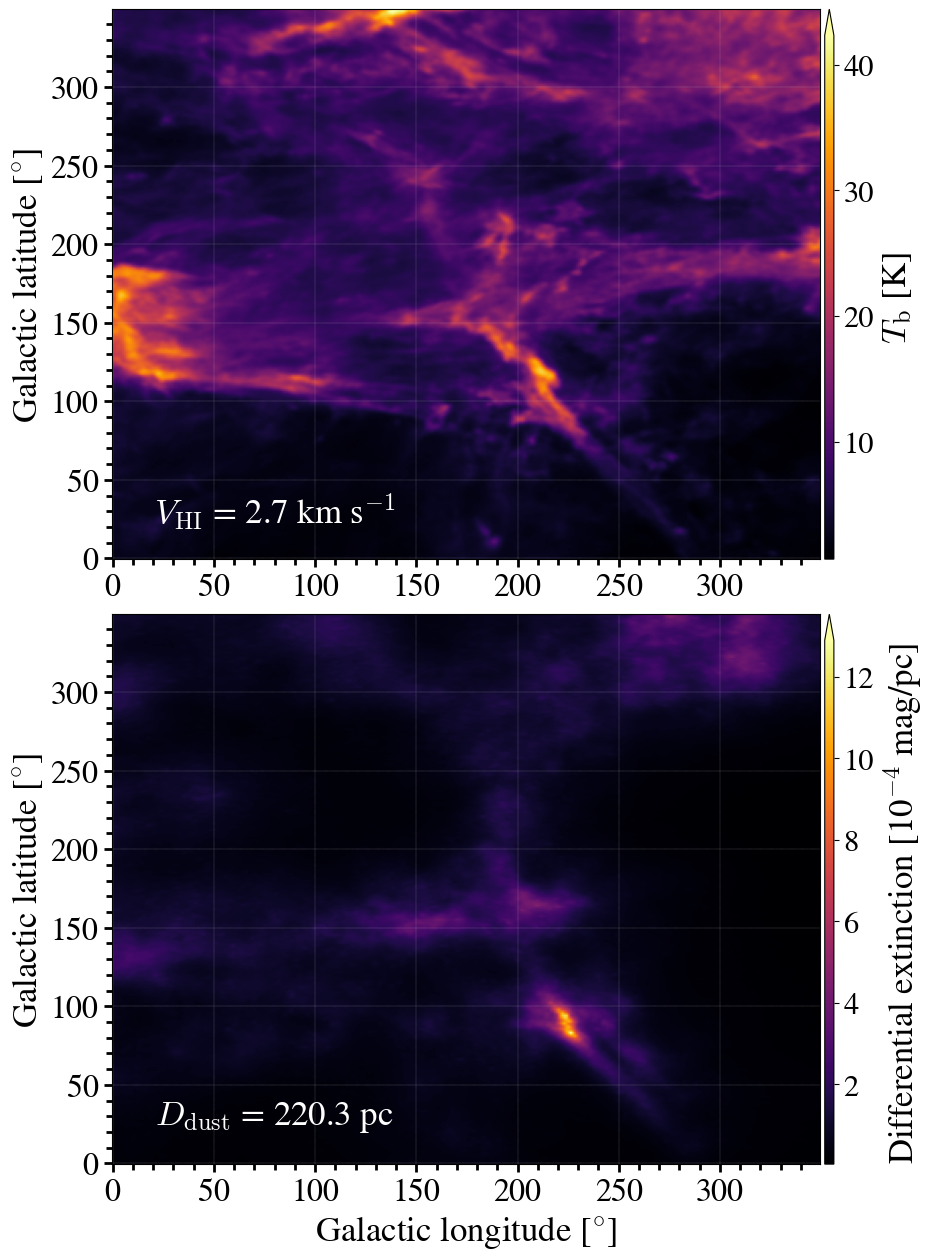

In [ ]:
xlbs = 25
tlbs = 23
cmap = 'viridis'

cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


# Plot
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(211) # projection=w

# Display the moment map image
im = ax.imshow(hi3d_data['ppvcube'][28, :, :], cmap='inferno', origin='lower', aspect='auto')
ax.text(80, 30, '$V_\mathrm{HI}$ = 2.7 km s$^{-1}$', dict(size=25, color='white'), horizontalalignment='center',  verticalalignment='center', ) # transform=ax.get_transform('galactic')



# Add axes labels
ax.set_ylabel('Galactic latitude [$^{\circ}$]', fontsize=xlbs)

# Color bar
cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', fraction=0.08, pad=0.006, aspect=60)
cbar.ax.set_ylabel('$T_\mathrm{b}$ [K]', rotation=90, labelpad=5., fontsize=xlbs)
cbar.ax.tick_params(labelsize=22)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)






################

ax = fig.add_subplot(212) # projection=w

dxfactor = 2.8 * 5.8e21 # See section 2.1, below Fig 3, https://www.aanda.org/articles/aa/pdf/2025/03/aa53022-24.pdf

# Display image
im = ax.imshow(1.e4*hi3d_data['ppdcube'][221, :, :]/dxfactor, cmap='inferno', origin='lower', aspect='auto')

ax.text(80, 30, '$D_\mathrm{dust}$ = 220.3 pc', dict(size=25, color='white'), horizontalalignment='center',  verticalalignment='center', ) # transform=ax.get_transform('galactic')


# Add axes labels
ax.set_xlabel('Galactic longitude [$^{\circ}$]', fontsize=xlbs)
ax.set_ylabel('Galactic latitude [$^{\circ}$]', fontsize=xlbs)

# Color bar
cbar = fig.colorbar(im, ax=ax, extend='max', orientation='vertical', fraction=0.08, pad=0.006, aspect=60)
cbar.ax.set_ylabel('Differential extinction [10$^{-4}$ mag/pc]', rotation=90, labelpad=5., fontsize=xlbs)
cbar.ax.tick_params(labelsize=22)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=4)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)



# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.1
                    )



plt.show()

In [ ]:
distmat = hi3d_data['distmat'].flatten()
vlsrmat = hi3d_data['vlsrmat'].flatten()
vscore = hi3d_data['Vd'].flatten()
v0score = hi3d_data['V'].flatten()

In [ ]:
# Find the index of the maximum value in flattened array
flat_index = np.argmax(vscore)

# Convert the flat index to 2D coordinates
max_indices = np.unravel_index(flat_index, hi3d_data['Vd'].shape)

print(f"Maximum value: {hi3d_data['Vd'][max_indices]}")
print(f"Indices of maximum value: {max_indices}")

Maximum value: 63.05271943235435
Indices of maximum value: (np.int64(204), np.int64(21))


In [ ]:
distmat[flat_index]

np.float64(220.32266806498973)

In [ ]:
vlsrmat[flat_index]

np.float64(2.677387341253714)

In [ ]:
# Find the index of the maximum value in flattened array
flat_index0 = np.argmax(v0score)

# Convert the flat index to 2D coordinates
max_indices = np.unravel_index(flat_index0, hi3d_data['V'].shape)

print(f"Maximum value: {hi3d_data['V'][max_indices]}")
print(f"Indices of maximum value: {max_indices}")

Maximum value: 23.644738655013438
Indices of maximum value: (np.int64(204), np.int64(21))


In [ ]:
# Interpolate Z values on the grid
from scipy.interpolate import griddata

Z0i = griddata((distmat, vlsrmat), v0score, (Xi, Yi), method='cubic')

In [ ]:
# Find the indices of the maximum values along axis 0 of Z
max_indices_Z = np.argmax(hi3d_data['Vd'], axis=1)
max_indices_Z.shape

(260,)

In [ ]:
# Find the indices of the maximum values along axis 0 of Z
max_indices_Z0 = np.argmax(hi3d_data['V'], axis=1)
max_indices_Z0.shape

(260,)

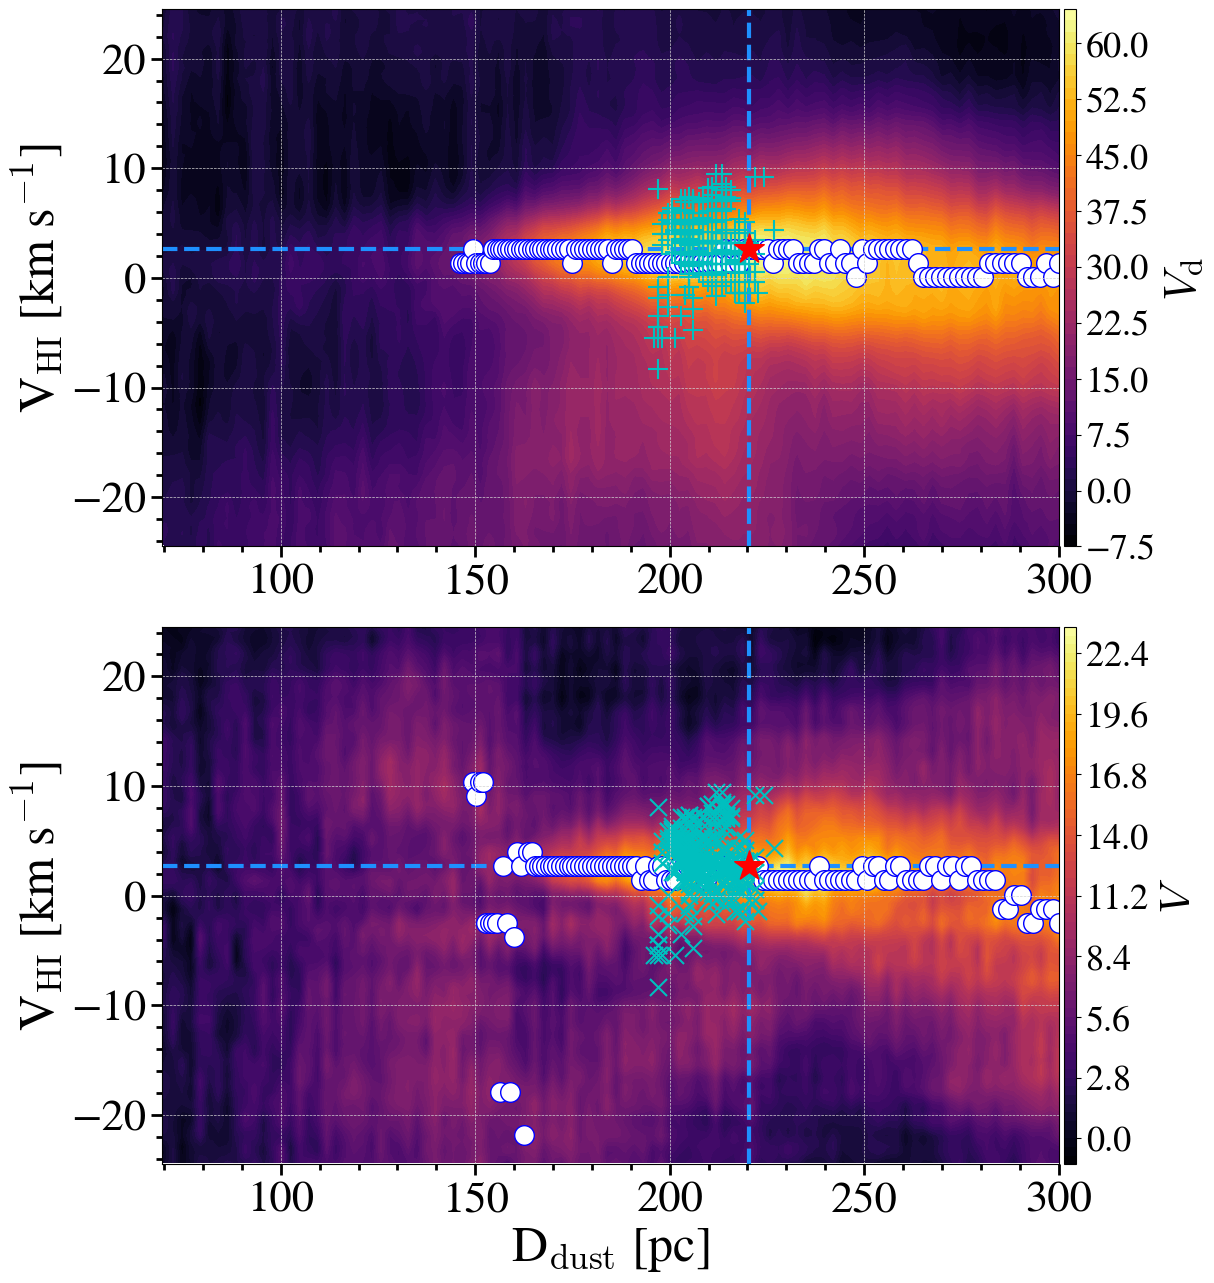

In [ ]:
# Plot
fig = plt.figure(figsize=(12,15))

# cm = mpl.cm.get_cmap('cool') # winter, cool, hsv

ax = plt.subplot(211)


# Create contour plot
contour = ax.contourf(Xi, Yi, Zi, 60, cmap='inferno') #coolwarm
ax.scatter(vlsrmat, distmat, c='white', s=10, alpha=0.5)  # Show original points

ax.scatter(distmat[flat_index], vlsrmat[flat_index], zorder=3, s=500, marker='*',
                 c='r', #cmap=cm,
                 label=f'')

# Extract the X and Y coordinates corresponding to the maximum Z values
X_max_Z = hi3d_data['distmat'][np.arange(hi3d_data['distmat'].shape[0]), max_indices_Z]
Y_max_Z = hi3d_data['vlsrmat'][np.arange(hi3d_data['distmat'].shape[0]), max_indices_Z]

X_max_Z[X_max_Z < 146.] = np.nan
Y_max_Z[X_max_Z < 146.] = np.nan

ax.axvline(x=distmat[flat_index], color='dodgerblue', ls='--', lw=3, zorder=1, label='')
ax.axhline(y=vlsrmat[flat_index], color='dodgerblue', ls='--', lw=3, zorder=1, label='')

# Mark these maximum locations on the X-Y plot
ax.scatter(X_max_Z, Y_max_Z, color='w', marker='o', s=200, zorder=1, edgecolors='b', label='')



ax.scatter(dust_tau_max_dist_arr, hi_tb_max_vlsr_arr, zorder=1, s=200, marker='+',
                 c='c',
                 label=f'')



ax.set_ylabel(r'V$_\mathrm{HI}$ [km s$^{-1}$]', fontsize=36, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=32, pad=4)
ax.tick_params(axis='y', labelsize=32)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

ax.set_xlim(69.5, 300.)
ax.set_ylim(-24.5, 24.5)

# Color bar
cbar = fig.colorbar(contour, ax=ax, orientation='vertical', fraction=0.03, pad=0.006, aspect=45)
cbar.ax.set_ylabel(r'$V_\mathrm{d}$', rotation=90, labelpad=5., fontsize=32)
cbar.ax.tick_params(labelsize=26)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)






# Axis
ax = plt.subplot(212)

# Create contour plot
contour = ax.contourf(Xi, Yi, Z0i, 60, cmap='inferno') #coolwarm inferno
ax.scatter(vlsrmat, distmat, c='white', s=10, alpha=0.5)  # Show original points

ax.scatter(distmat[flat_index], vlsrmat[flat_index], zorder=3, s=500, marker='*',
                 c='r', #cmap=cm,
                 label=f'')



ax.axvline(x=distmat[flat_index0], color='dodgerblue', ls='--', lw=3, zorder=1, label='')
ax.axhline(y=vlsrmat[flat_index0], color='dodgerblue', ls='--', lw=3, zorder=1, label='')







# Extract the X and Y coordinates corresponding to the maximum Z values
X_max_Z0 = hi3d_data['distmat'][np.arange(hi3d_data['distmat'].shape[0]), max_indices_Z0]
Y_max_Z0 = hi3d_data['vlsrmat'][np.arange(hi3d_data['distmat'].shape[0]), max_indices_Z0]

X_max_Z0[X_max_Z0 < 149.] = np.nan
Y_max_Z0[X_max_Z0 < 149.] = np.nan

# Mark these maximum locations on the X-Y plot
ax.scatter(X_max_Z0, Y_max_Z0, color='w', marker='o', s=200, zorder=1, edgecolors='b', label='')


ax.scatter(dust_tau_max_dist_arr, hi_tb_max_vlsr_arr, zorder=1, s=150, marker='x',
                 c='c',
                 label=f'')



ax.set_xlabel(r'D$_\mathrm{dust}$ [pc]', fontsize=36)
ax.set_ylabel(r'V$_\mathrm{HI}$ [km s$^{-1}$]', fontsize=36, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=32, pad=4)
ax.tick_params(axis='y', labelsize=32)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

ax.set_xlim(69.5, 300.)
ax.set_ylim(-24.5, 24.5)

# Color bar
cbar = fig.colorbar(contour, ax=ax, orientation='vertical', fraction=0.03, pad=0.006, aspect=45)
cbar.ax.set_ylabel(r'$V_\mathrm{}$', rotation=90, labelpad=5., fontsize=32)
cbar.ax.tick_params(labelsize=26)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.15
                    )

plt.show()

# Saha equation

In [ ]:
sp.Planck

6.62607015e-34

In [ ]:
k_B = 1.380649e-23
m_e = 9.109e-31     # Electron mass in kg
h = 6.626e-34       # Planck constant in J*s

# Saha equation function
def saha_fraction(T, chi, n_e):
    # k_B = 8.617e-5      # Boltzmann constant in eV/K
    chi = chi * 1.60218e-19
    saha_prefactor = (2 * np.pi * m_e * k_B * T / h**2)**(3/2) # * 1e-6  # in cm^-3 because n_e in cm-3
    ratio = (saha_prefactor / n_e / 1.e-6) # * (2 * gp / g0)
    exp_term = np.exp(-chi / (k_B * T))
    ratio = ratio * exp_term
    return ratio / (1 + ratio)

In [ ]:
# Physical constants
k_B = 1.380649e-23
m_e = 9.109e-31     # Electron mass in kg
h = 6.626e-34       # Planck constant in J*s

# Ionization energies (eV)
chi_H = 13.6        # Hydrogen
chi_K = 4.34        # Potassium

# Statistical weights
g_H0, g_Hp = 2, 1   # H I, H II
g_K0, g_Kp = 2, 1   # K I, K II

# Temperature range (K)
T_vals = np.linspace(10, 20000, 500)

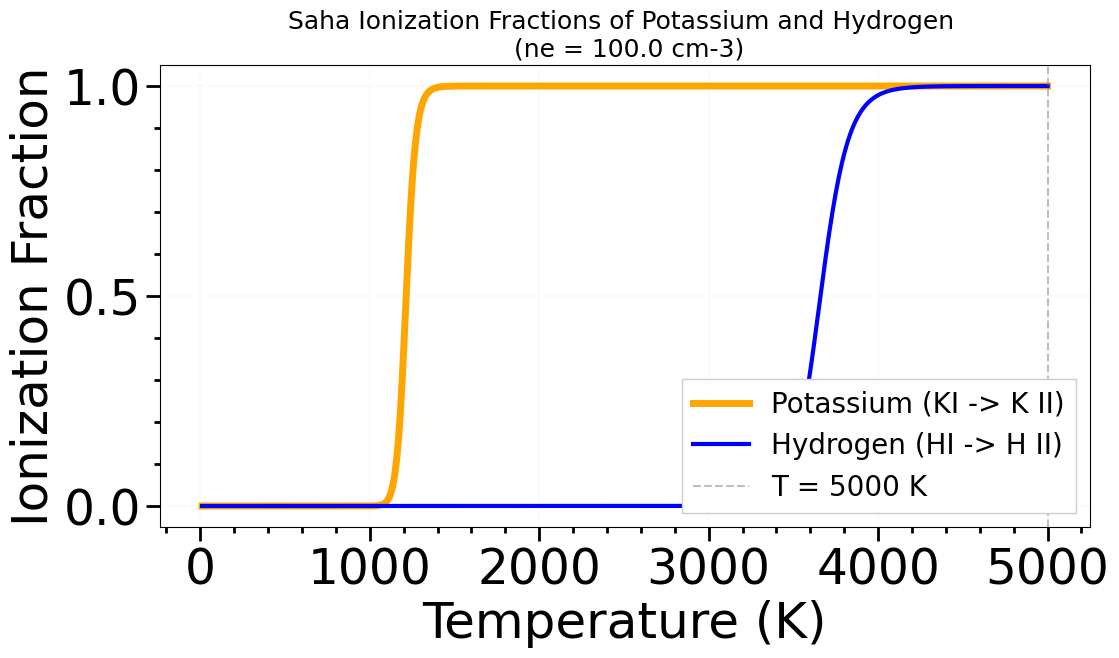

In [ ]:
# Electron density (cm^-3)
n_e = 100.

# Temperature range (K)
T_vals = np.linspace(10, 5000, 500)

# Compute ionization fractions
f_K = saha_fraction(T_vals, chi_K, n_e, g_K0, g_Kp)
f_H = saha_fraction(T_vals, chi_H, n_e, g_H0, g_Hp)


xlbs = 36
tlbs = 35
cmap = 'viridis'

# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111) # projection=w

ax.plot(T_vals, f_K, label='Potassium (KI -> K II)', color='orange', lw=5)
ax.plot(T_vals, f_H, label='Hydrogen (HI -> H II)', color='blue', lw=3)

ax.axvline(5000, color='gray', linestyle='--', alpha=0.5, label='T = 5000 K')



# Title
ax.set_title(f"Saha Ionization Fractions of Potassium and Hydrogen \n (ne = {n_e} cm-3)", fontsize=18)

# Add axes labels
ax.set_xlabel('Temperature (K)', fontsize=xlbs)
ax.set_ylabel('Ionization Fraction', fontsize=xlbs)


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=4)

ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=20)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

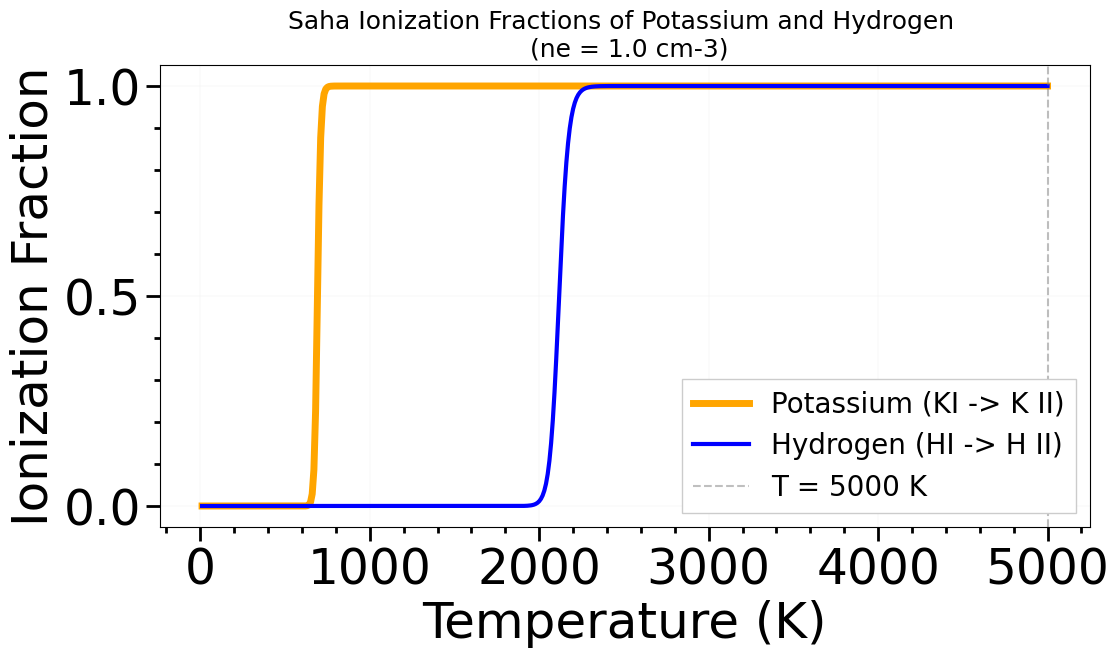

In [ ]:
# Electron density (cm^-3)
n_e = 1.

# Temperature range (K)
T_vals = np.linspace(10, 5000, 500)

# # Compute ionization fractions
f_K = saha_fraction(T_vals, chi_K, n_e)
f_H = saha_fraction(T_vals, chi_H, n_e)




# Plot
xlbs = 36
tlbs = 35
cmap = 'viridis'

cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111) # projection=w

ax.plot(T_vals, f_K, label='Potassium (KI -> K II)', color='orange', lw=5)
ax.plot(T_vals, f_H, label='Hydrogen (HI -> H II)', color='blue', lw=3)

ax.axvline(5000, color='gray', linestyle='--', alpha=0.5, label='T = 5000 K')



# Title
ax.set_title(f"Saha Ionization Fractions of Potassium and Hydrogen \n (ne = {n_e} cm-3)", fontsize=18)

# Add axes labels
ax.set_xlabel('Temperature (K)', fontsize=xlbs)
ax.set_ylabel('Ionization Fraction', fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=4)

ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=20)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

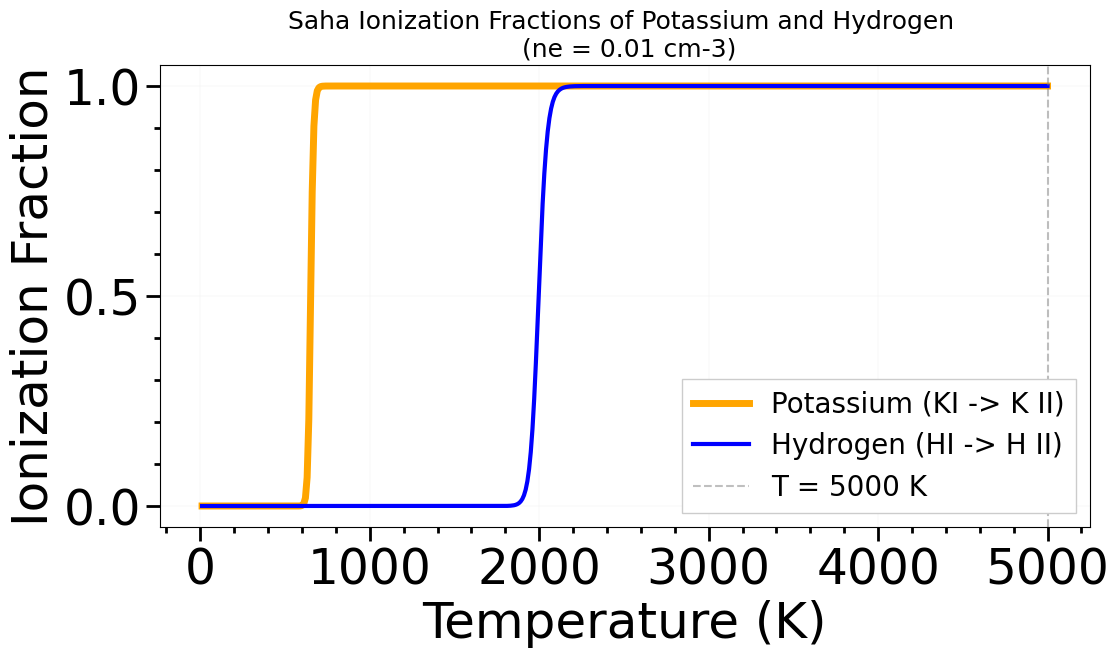

In [ ]:
# Electron density (cm^-3)
n_e = 0.01

# Temperature range (K)
T_vals = np.linspace(10, 5000, 500)

f_K = saha_fraction(T_vals, chi_K, n_e)
f_H = saha_fraction(T_vals, chi_H, n_e)




# Plot
xlbs = 36
tlbs = 35
cmap = 'viridis'

cm = mpl.colormaps['cool'] # winter, cool, hsv, jet


# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111) # projection=w

ax.plot(T_vals, f_K, label='Potassium (KI -> K II)', color='orange', lw=5)
ax.plot(T_vals, f_H, label='Hydrogen (HI -> H II)', color='blue', lw=3)

ax.axvline(5000, color='gray', linestyle='--', alpha=0.5, label='T = 5000 K')



# Title
ax.set_title(f"Saha Ionization Fractions of Potassium and Hydrogen \n (ne = {n_e} cm-3)", fontsize=18)

# Add axes labels
ax.set_xlabel('Temperature (K)', fontsize=xlbs)
ax.set_ylabel('Ionization Fraction', fontsize=xlbs)


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=4)

ax.legend(loc='lower right', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', fontsize=20)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()